# CelebA-HQ DataLoader Visualization

This notebook demonstrates the CelebA-HQ dataloader implementation for FlexTok fine-tuning.

## Features:
- Load CelebA-HQ images with proper preprocessing
- Normalize to [-1, 1] range (FlexTok expected format)
- Support for train/val/test splits
- Visualization of batches and preprocessing effects
- Data augmentation examples

In [1]:
import sys
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from flextok.utils.dataloader import CelebAHQDataset, create_celebahq_dataloader
from flextok.utils.demo import denormalize, batch_to_pil

# Set up plotting
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

## 1. Setup Dataset Path

**Important:** You need to download CelebA-HQ first!

### Option 1: Download from Hugging Face (Recommended)

In [ ]:
from datasets import load_dataset
import os

# Download CelebA-HQ 256x256 from Hugging Face
dataset = load_dataset("korexyz/celeba-hq-256x256")

# Save images to disk
os.makedirs("./data/celeba_hq/images", exist_ok=True)
for idx, sample in enumerate(dataset['train']):
    sample['image'].save(f"./data/celeba_hq/images/{idx:05d}.jpg")

KeyboardInterrupt: 

### Option 2: Download from Kaggle
- Visit: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256

## 2. Create Dataset and DataLoader

The dataset is split into:
- **Train**: 27,000 images (indices 0-26999)
- **Val**: 1,500 images (indices 27000-28499)
- **Test**: 1,500 images (indices 28500-29999)

In [ ]:
# Create dataset
IMG_SIZE = 256
BATCH_SIZE = 16
DATASET_PATH = "./data/celeba_hq/"

# Training dataset
train_dataset = CelebAHQDataset(
    root_dir=DATASET_PATH,
    img_size=IMG_SIZE,
    split="train",
)

# Validation dataset
val_dataset = CelebAHQDataset(
    root_dir=DATASET_PATH,
    img_size=IMG_SIZE,
    split="val",
)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Val dataset: {len(val_dataset)} images")
print(f"\nDataset info: {train_dataset}")

Train dataset: 27000 images
Val dataset: 1000 images

Dataset info: CelebAHQDataset(root_dir=data/celeba_hq, img_size=256, split=train, num_images=27000)


In [8]:
# Create dataloaders using the convenience function
train_loader = create_celebahq_dataloader(
    root_dir=DATASET_PATH,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    split="train",
    num_workers=2,  # Adjust based on your CPU
)

val_loader = create_celebahq_dataloader(
    root_dir=DATASET_PATH,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    split="val",
    shuffle=False,
    num_workers=2,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 1688
Val batches: 63


## 3. Visualize Single Image

Let's examine a single image and verify the preprocessing.

Image shape: torch.Size([3, 256, 256])
Image dtype: torch.float32
Value range: [-1.000, 0.992]
Mean: -0.571
Std: 0.455


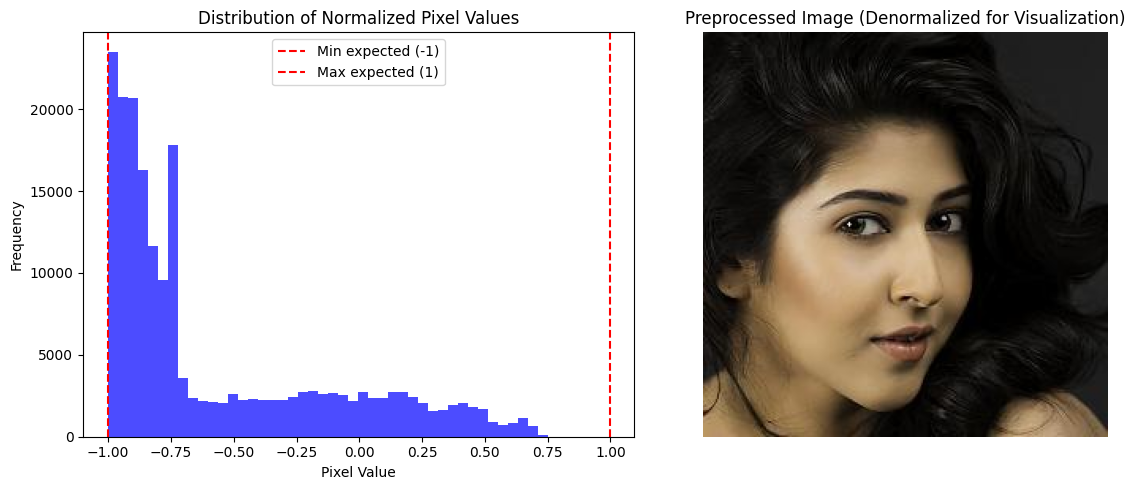

In [10]:
# Get a single image
img_tensor = train_dataset[0]

print(f"Image shape: {img_tensor.shape}")
print(f"Image dtype: {img_tensor.dtype}")
print(f"Value range: [{img_tensor.min():.3f}, {img_tensor.max():.3f}]")
print(f"Mean: {img_tensor.mean():.3f}")
print(f"Std: {img_tensor.std():.3f}")

# Denormalize and visualize
img_denorm = denormalize(img_tensor)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Show histogram of normalized values
axes[0].hist(img_tensor.flatten().numpy(), bins=50, alpha=0.7, color='blue')
axes[0].set_title("Distribution of Normalized Pixel Values")
axes[0].set_xlabel("Pixel Value")
axes[0].set_ylabel("Frequency")
axes[0].axvline(x=-1, color='r', linestyle='--', label='Min expected (-1)')
axes[0].axvline(x=1, color='r', linestyle='--', label='Max expected (1)')
axes[0].legend()

# Show the image
axes[1].imshow(img_denorm.permute(1, 2, 0).clamp(0, 1).numpy())
axes[1].set_title("Preprocessed Image (Denormalized for Visualization)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4. Visualize a Batch

Let's load a batch and visualize multiple images at once.

Batch shape: torch.Size([16, 3, 256, 256])
Batch dtype: torch.float32
Batch value range: [-1.000, 1.000]


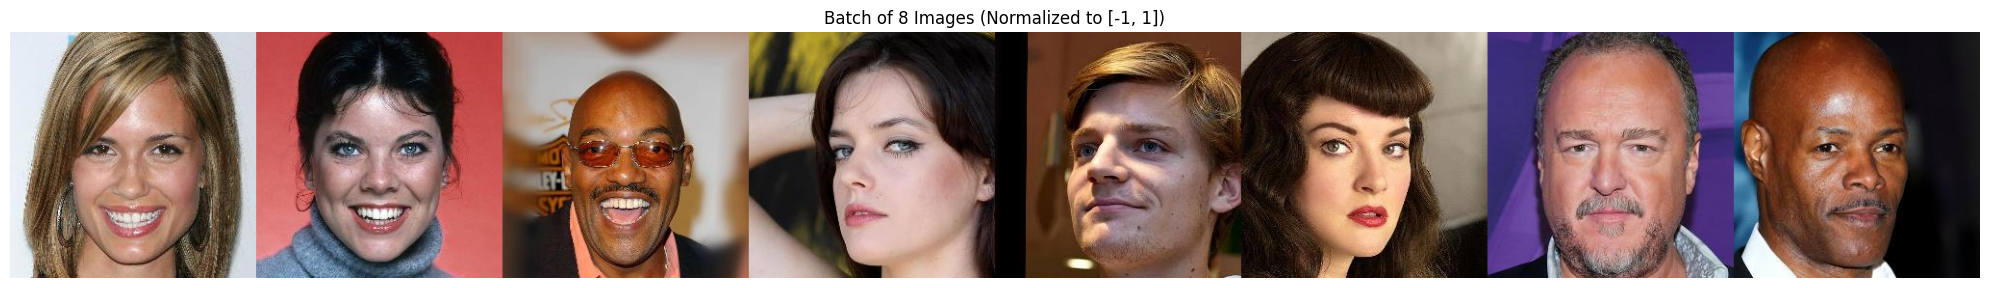

In [13]:
# Get a batch from the dataloader
batch = next(iter(train_loader))

print(f"Batch shape: {batch.shape}")
print(f"Batch dtype: {batch.dtype}")
print(f"Batch value range: [{batch.min():.3f}, {batch.max():.3f}]")

# Visualize the batch using batch_to_pil helper
batch_img = batch_to_pil(batch[:8], stack_horizontal=True)  # Show first 8 images

plt.figure(figsize=(20, 4))
plt.imshow(batch_img)
plt.title(f"Batch of {min(8, len(batch))} Images (Normalized to [-1, 1])")
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Visualize Multiple Batches in Grid

Create a grid visualization to see more examples.

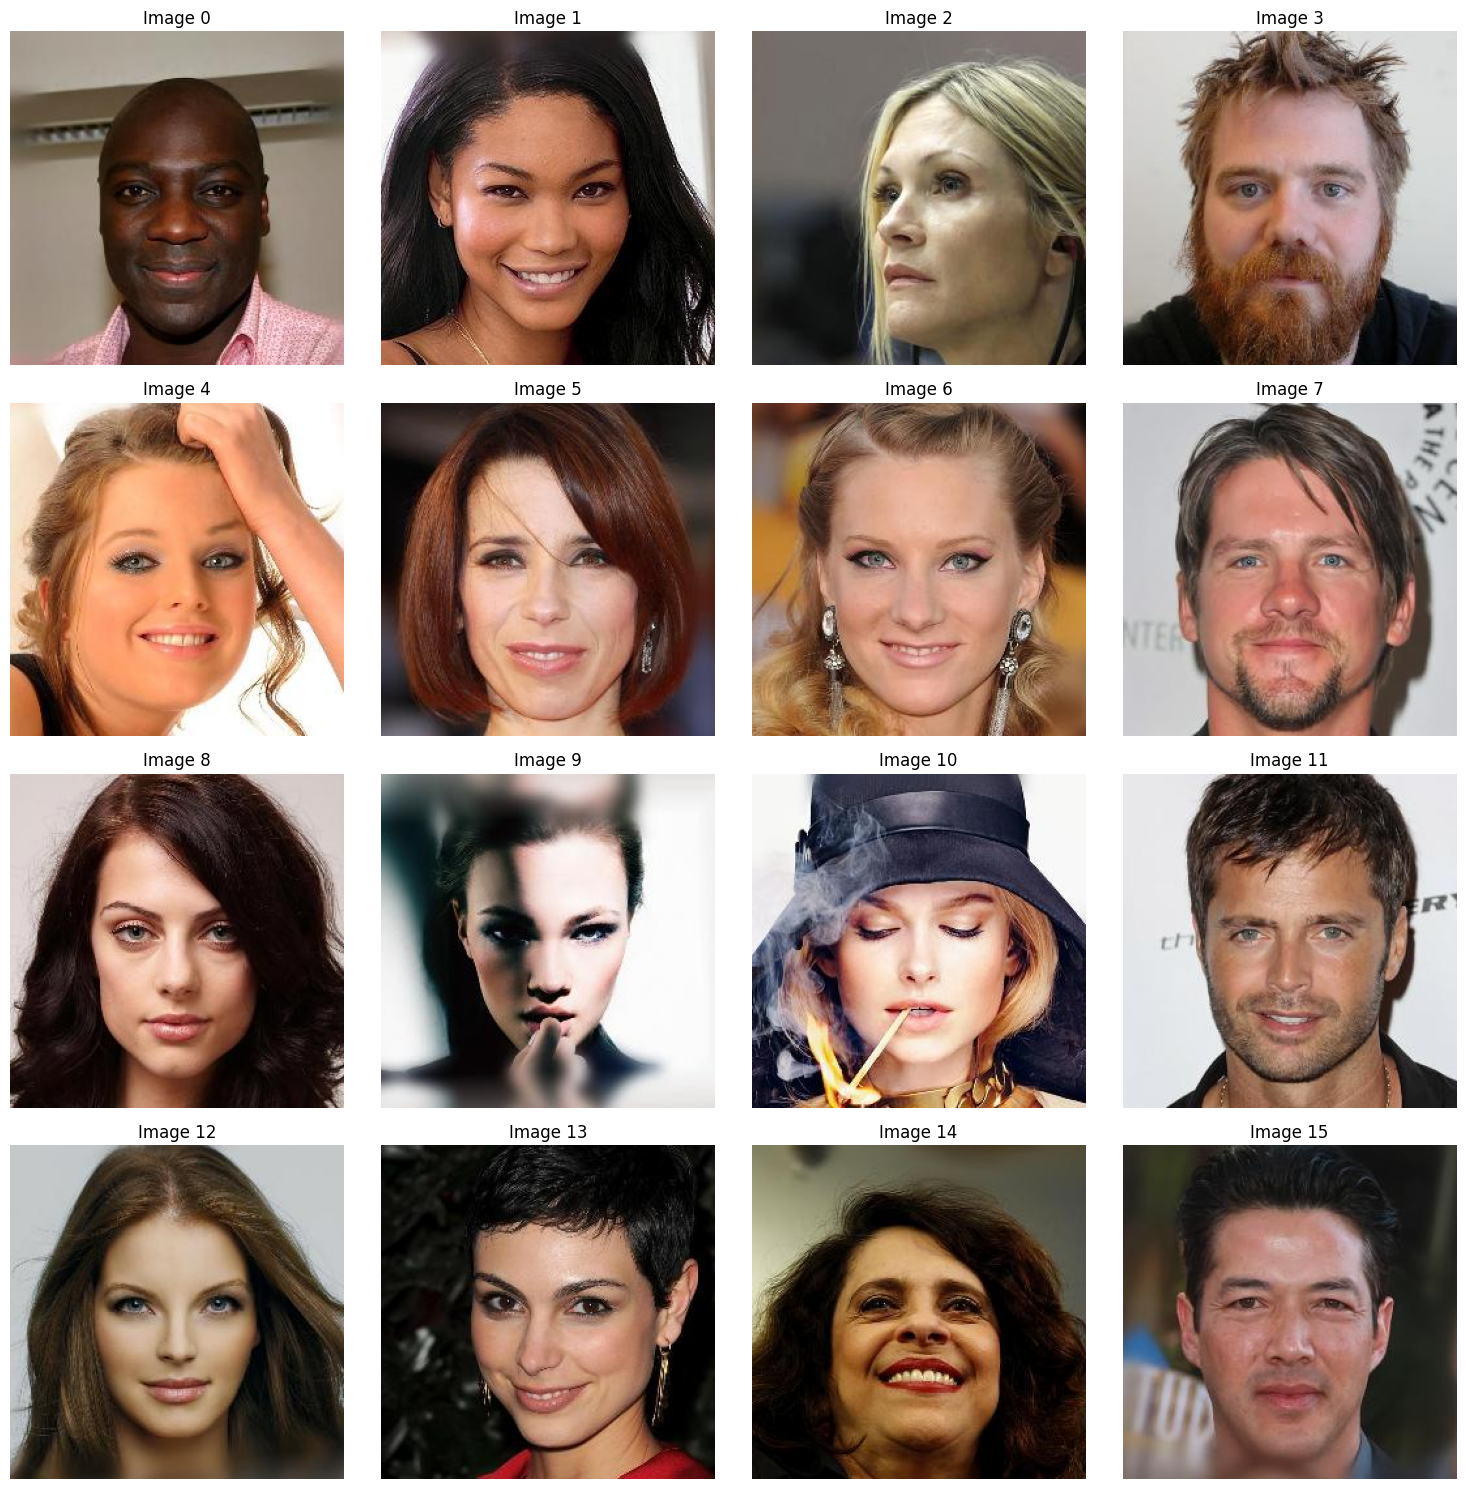

In [14]:
def visualize_batch_grid(batch, num_images=16, nrows=4, figsize=(15, 15)):
    """
    Visualize a batch of images in a grid.
    
    Args:
        batch: Tensor of shape (B, C, H, W)
        num_images: Number of images to show
        nrows: Number of rows in grid
    """
    num_images = min(num_images, len(batch))
    ncols = (num_images + nrows - 1) // nrows
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for idx in range(num_images):
        img = denormalize(batch[idx]).permute(1, 2, 0).clamp(0, 1).numpy()
        axes[idx].imshow(img)
        axes[idx].set_title(f"Image {idx}")
        axes[idx].axis('off')
    
    # Hide remaining subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a batch and visualize
batch = next(iter(train_loader))
visualize_batch_grid(batch, num_images=16, nrows=4)

## 6. Data Augmentation Examples

For fine-tuning, you might want to add data augmentation. Here's how to do it with the dataloader.

Comparing original vs augmented images (refresh to see different flips)



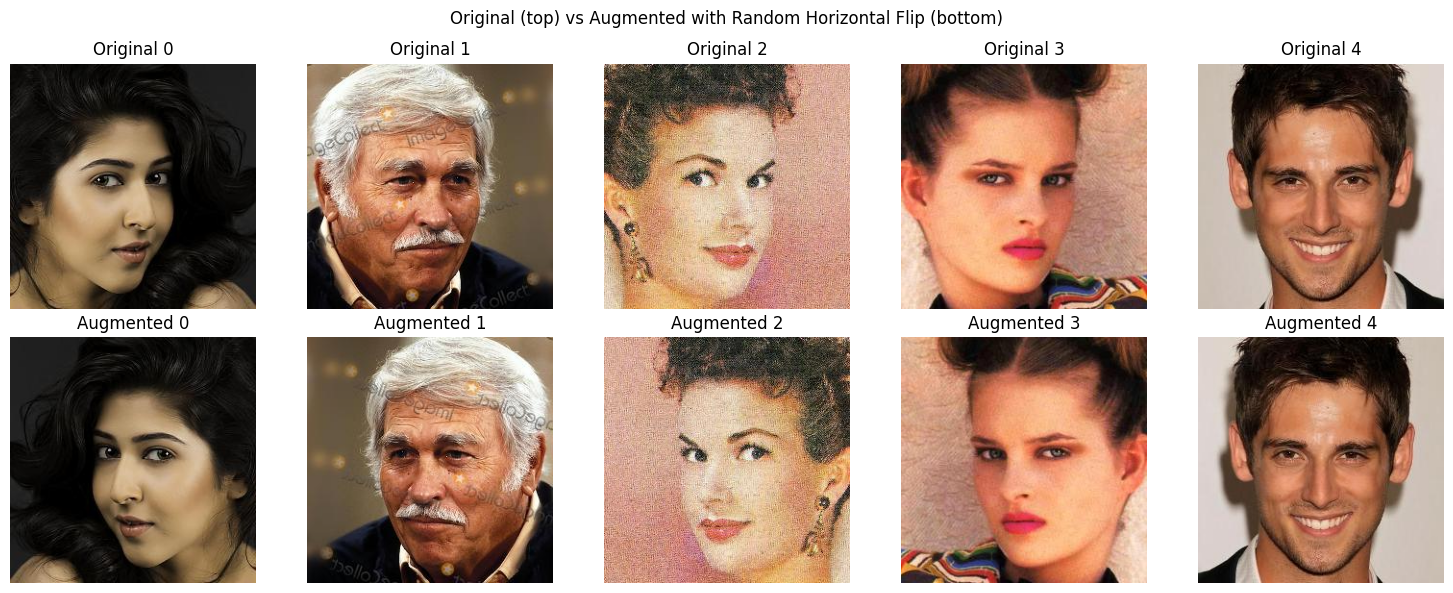

In [15]:
# Define augmentation transforms
# Note: These are applied AFTER normalization, so they work on [-1, 1] tensors
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    # Add more augmentations here if needed
])

# Create dataset with augmentation
augmented_dataset = CelebAHQDataset(
    root_dir=DATASET_PATH,
    img_size=IMG_SIZE,
    split="train",
    transform=augmentation_transforms,
)

# Compare original vs augmented
print("Comparing original vs augmented images (refresh to see different flips)\n")

# Get same image multiple times to see augmentation variations
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Original (no augmentation)
for i in range(5):
    img = train_dataset[i]  # No augmentation
    img_denorm = denormalize(img).permute(1, 2, 0).clamp(0, 1).numpy()
    axes[0, i].imshow(img_denorm)
    axes[0, i].set_title(f"Original {i}")
    axes[0, i].axis('off')

# Augmented
for i in range(5):
    img = augmented_dataset[i]  # With augmentation
    img_denorm = denormalize(img).permute(1, 2, 0).clamp(0, 1).numpy()
    axes[1, i].imshow(img_denorm)
    axes[1, i].set_title(f"Augmented {i}")
    axes[1, i].axis('off')

fig.suptitle("Original (top) vs Augmented with Random Horizontal Flip (bottom)")
plt.tight_layout()
plt.show()

## 7. Verify FlexTok Compatibility

Let's verify that our dataloader output is compatible with FlexTok's expected input format.

In [16]:
# Check FlexTok compatibility
batch = next(iter(train_loader))

print("=" * 60)
print("FLEXTOK COMPATIBILITY CHECK")
print("=" * 60)

checks = [
    ("Shape is (B, 3, H, W)", batch.shape[1:] == torch.Size([3, IMG_SIZE, IMG_SIZE])),
    ("Dtype is float32", batch.dtype == torch.float32),
    ("Values in [-1, 1] range", batch.min() >= -1.1 and batch.max() <= 1.1),
    ("Normalized (mean ≈ 0)", abs(batch.mean()) < 0.5),
    ("Batch size is correct", batch.shape[0] == BATCH_SIZE),
]

all_passed = True
for check_name, passed in checks:
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"{status}: {check_name}")
    all_passed = all_passed and passed

print("=" * 60)
if all_passed:
    print("All checks passed! Dataloader is compatible with FlexTok.")
else:
    print("Some checks failed. Please review the dataloader configuration.")
print("=" * 60)

print(f"\nDetailed stats:")
print(f"  Batch shape: {batch.shape}")
print(f"  Value range: [{batch.min():.4f}, {batch.max():.4f}]")
print(f"  Mean: {batch.mean():.4f}")
print(f"  Std: {batch.std():.4f}")

FLEXTOK COMPATIBILITY CHECK
✓ PASS: Shape is (B, 3, H, W)
✓ PASS: Dtype is float32
✓ PASS: Values in [-1, 1] range
✓ PASS: Normalized (mean ≈ 0)
✓ PASS: Batch size is correct
All checks passed! Dataloader is compatible with FlexTok.

Detailed stats:
  Batch shape: torch.Size([16, 3, 256, 256])
  Value range: [-1.0000, 1.0000]
  Mean: -0.1677
  Std: 0.5640


## 8. Performance Benchmarking

Let's measure the dataloader throughput to ensure it won't bottleneck training.

In [17]:
import time

def benchmark_dataloader(loader, num_batches=50, warmup=5):
    """
    Benchmark dataloader throughput.
    
    Args:
        loader: DataLoader to benchmark
        num_batches: Number of batches to measure
        warmup: Number of warmup batches (not counted)
    """
    print(f"Benchmarking dataloader (warmup: {warmup}, measured: {num_batches})...")
    
    # Warmup
    for i, batch in enumerate(loader):
        if i >= warmup:
            break
    
    # Measure
    start_time = time.time()
    batch_times = []
    
    for i, batch in enumerate(loader):
        if i >= num_batches:
            break
        batch_start = time.time()
        _ = batch  # Access the batch
        batch_times.append(time.time() - batch_start)
    
    total_time = time.time() - start_time
    
    # Calculate stats
    avg_batch_time = total_time / num_batches
    images_per_sec = (num_batches * loader.batch_size) / total_time
    
    print(f"\nResults:")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Avg batch time: {avg_batch_time*1000:.2f}ms")
    print(f"  Throughput: {images_per_sec:.2f} images/sec")
    print(f"  Batches/sec: {num_batches/total_time:.2f}")
    
    return {
        'total_time': total_time,
        'avg_batch_time': avg_batch_time,
        'throughput': images_per_sec,
    }

# Benchmark with different num_workers
print("\n" + "="*60)
print("DATALOADER PERFORMANCE BENCHMARK")
print("="*60 + "\n")

benchmark_results = {}

for num_workers in [0, 2, 4]:
    print(f"\nTesting with num_workers={num_workers}:")
    print("-" * 40)
    
    loader = create_celebahq_dataloader(
        root_dir=DATASET_PATH,
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        num_workers=num_workers,
        split="train",
    )
    
    results = benchmark_dataloader(loader, num_batches=30, warmup=5)
    benchmark_results[num_workers] = results

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

workers = list(benchmark_results.keys())
throughputs = [benchmark_results[w]['throughput'] for w in workers]
batch_times = [benchmark_results[w]['avg_batch_time'] * 1000 for w in workers]  # Convert to ms

ax1.bar(workers, throughputs, color='steelblue')
ax1.set_xlabel('Number of Workers')
ax1.set_ylabel('Throughput (images/sec)')
ax1.set_title('DataLoader Throughput')
ax1.grid(True, alpha=0.3)

ax2.bar(workers, batch_times, color='coral')
ax2.set_xlabel('Number of Workers')
ax2.set_ylabel('Avg Batch Time (ms)')
ax2.set_title('Average Batch Loading Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
optimal_workers = max(benchmark_results.keys(), key=lambda w: benchmark_results[w]['throughput'])
print(f"Optimal num_workers: {optimal_workers}")
print(f"Peak throughput: {benchmark_results[optimal_workers]['throughput']:.2f} images/sec")
print("="*60)


DATALOADER PERFORMANCE BENCHMARK


Testing with num_workers=0:
----------------------------------------
Benchmarking dataloader (warmup: 5, measured: 30)...


KeyboardInterrupt: 

## 9. Compare Train/Val/Test Splits

Verify that the splits are working correctly.

/home/iyu/ml-flextok/flextok/utils/dataloader.py:119: UserWarning: No images found for split 'test' in range [28500, 30000). Total images found: 0
  warnings.warn(


Dataset splits:
TRAIN :  27000 images
VAL   :   1000 images
TEST  :      0 images
Total:   28000 images


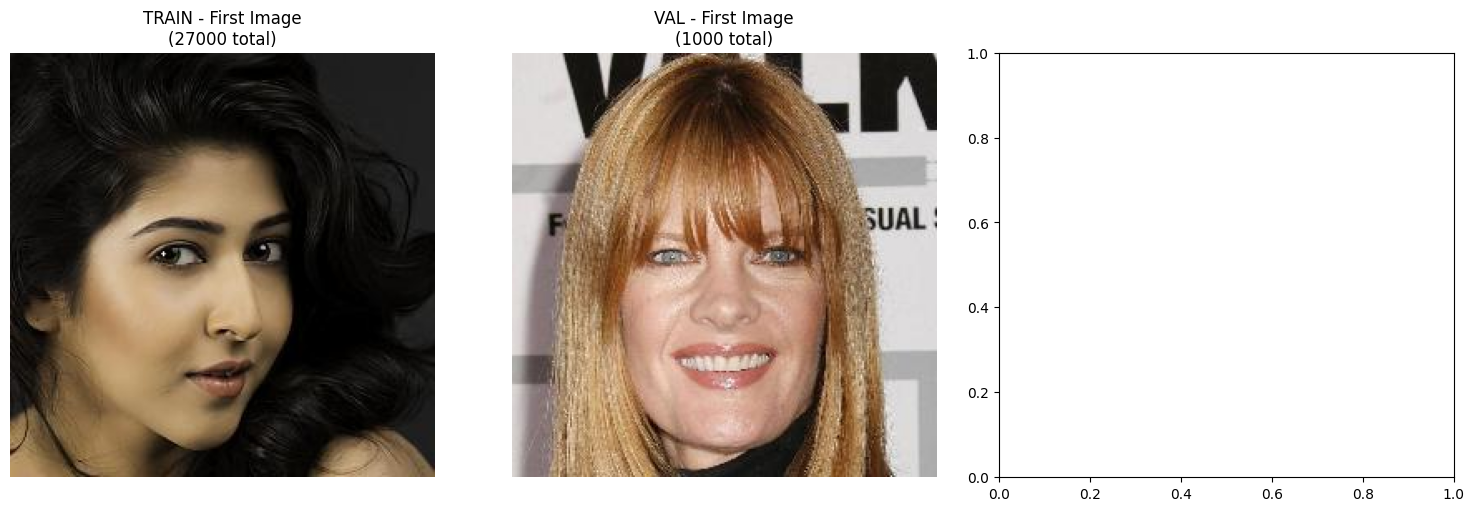

In [18]:
# Create all three splits
splits = {}
for split_name in ['train', 'val', 'test']:
    splits[split_name] = CelebAHQDataset(
        root_dir=DATASET_PATH,
        img_size=IMG_SIZE,
        split=split_name,
    )

print("Dataset splits:")
print("=" * 60)
for split_name, dataset in splits.items():
    print(f"{split_name.upper():6s}: {len(dataset):6d} images")
print("=" * 60)
print(f"Total:  {sum(len(d) for d in splits.values()):6d} images")

# Visualize one image from each split
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (split_name, dataset) in enumerate(splits.items()):
    if len(dataset) > 0:
        img = denormalize(dataset[0]).permute(1, 2, 0).clamp(0, 1).numpy()
        axes[idx].imshow(img)
        axes[idx].set_title(f"{split_name.upper()} - First Image\n({len(dataset)} total)")
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 10. Integration Example: Mock Training Loop

Example of how you would use this dataloader in a training loop.

In [19]:
def mock_training_loop(train_loader, val_loader, num_epochs=2, batches_per_epoch=10):
    """
    Mock training loop to demonstrate dataloader usage.
    
    In real training, you would:
    1. Load FlexTok model
    2. Setup optimizer
    3. Implement flow matching loss
    4. Run forward/backward passes
    """
    print("Starting mock training loop...\n")
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 60)
        
        # Training phase
        train_losses = []
        for batch_idx, batch in enumerate(train_loader):
            if batch_idx >= batches_per_epoch:
                break
            
            # Mock forward pass
            # In real training:
            # latents = model.vae.encode(batch)
            # encoded = model.encoder(latents)
            # quantized = model.regularizer(encoded)
            # ... flow matching training ...
            
            mock_loss = torch.rand(1).item()  # Mock loss
            train_losses.append(mock_loss)
            
            if (batch_idx + 1) % 5 == 0:
                print(f"  Batch {batch_idx + 1}/{batches_per_epoch} - "
                      f"Loss: {mock_loss:.4f} - "
                      f"Batch shape: {batch.shape}")
        
        avg_train_loss = np.mean(train_losses)
        
        # Validation phase
        val_losses = []
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                if batch_idx >= 5:  # Fewer val batches
                    break
                mock_loss = torch.rand(1).item()
                val_losses.append(mock_loss)
        
        avg_val_loss = np.mean(val_losses) if val_losses else 0.0
        
        print(f"\n  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss:   {avg_val_loss:.4f}")
    
    print("\n" + "="*60)
    print("Mock training completed!")
    print("="*60)

# Run mock training
mock_training_loop(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=2,
    batches_per_epoch=10
)

Starting mock training loop...


Epoch 1/2
------------------------------------------------------------
  Batch 5/10 - Loss: 0.4628 - Batch shape: torch.Size([16, 3, 256, 256])
  Batch 10/10 - Loss: 0.9324 - Batch shape: torch.Size([16, 3, 256, 256])

  Train Loss: 0.4510
  Val Loss:   0.4573

Epoch 2/2
------------------------------------------------------------
  Batch 5/10 - Loss: 0.4319 - Batch shape: torch.Size([16, 3, 256, 256])
  Batch 10/10 - Loss: 0.1341 - Batch shape: torch.Size([16, 3, 256, 256])

  Train Loss: 0.4955
  Val Loss:   0.7677

Mock training completed!


## Summary

This notebook demonstrated:

1. **CelebA-HQ Dataset Loading**: Proper loading with train/val/test splits
2. **Preprocessing**: Images normalized to [-1, 1] as required by FlexTok
3. **Visualization**: Multiple ways to inspect batches and individual images
4. **Data Augmentation**: How to add augmentation transforms
5. **Compatibility**: Verified FlexTok input format compatibility
6. **Performance**: Benchmarked dataloader throughput
7. **Integration**: Example of usage in training loop

### Next Steps for Real Training:

1. Download actual CelebA-HQ dataset
2. Load pre-trained FlexTok model
3. Implement flow matching training loop
4. Add proper loss computation
5. Set up optimizer and learning rate schedule
6. Add checkpointing and logging

### Recommended Configuration for Fine-tuning:

```python
# Training config
config = {
    'img_size': 256,
    'batch_size': 32,
    'num_workers': 4,  # Adjust based on your CPU
    'learning_rate': 1e-4,
    'epochs': 50,
    'augmentation': True,  # Use RandomHorizontalFlip
}

# Create dataloader
train_loader = create_celebahq_dataloader(
    root_dir='/path/to/celeba_hq',
    img_size=config['img_size'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    transform=transforms.RandomHorizontalFlip(p=0.5) if config['augmentation'] else None,
)
```